# Signed, directed, weighted graph representation learning

In [2]:
import imp
import csv
import torch
import random
import seaborn as sns
from cell.Word2vec.wv import *
from cell.Word2vec.dataloader import *
from cell.Word2vec.prepare_vocab import *
from stellargraph import StellarDiGraph
from cell import utils, plot_utils, graph_utils, analysis

import cell.BiasedDirectedWeightedWalk as BDWW
imp.reload(utils)

<module 'cell.utils' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/utils.py'>

In [3]:
cldf = utils.read_visp_npp_cldf("old")
ordered_cl = cldf.cluster_label.tolist() #This is the same order as Elife paper

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


The extended version of NPP-NPGPCR graphs were provided by S. Smith and they are saved in the following path: "/Users/fahimehb/Documents/NPP_GNN_project/dat/Cognate_Pairs.csv". Apart from 37 channels that were reported in Elife paper, there are 35 more pairs provided that we are going to use in this work:

In [21]:
Cognate_Pairs = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/Cognate_Pairs.csv")

In [22]:
Cognate_Pairs["layer"] = Cognate_Pairs['NPP'].str.cat(Cognate_Pairs['NP-GPCR'],sep="-")
Cognate_Pairs.head()

,NPP,NP-GPCR,Receptor Name,Class,Primary,Notes,ordinal,NPP.1,NP-GPCR.1,layer
0,Apln,Aplnr,Apelin receoptor,I,True,Added 10 Sep 2020,1.0000,Adcyap1,Adcyap1r1,Apln-Aplnr
1,Adcyap1,Adcyap1r1,Adenylate Cyclase Activating Peptide 1 Receptor 1,S,True,NaN,2.0000,Adm,Agtr1a,Adcyap1-Adcyap1r1
2,Vip,Adcyap1r1,Adenylate Cyclase Activating Peptide 1 Receptor 1,S,False,NaN,3.0000,Agt,Agtr2,Vip-Adcyap1r1
3,Agt,Agtr1a,"Angiotensin II Receptor, Type 1a",I,True,NaN,4.0000,Apln,Aplnr,Agt-Agtr1a
4,Agt,Agtr2,"Angiotensin Ii Receptor, Type 2",I,True,NaN,5.0000,Avp,Avpr1a,Agt-Agtr2


There are 3 different classes of NPP/NP-GPCR pairs, that are indicated with "I", "S" or "Q" in the file above. This classification is done based on the primary effect of the GPCRs expressed in cortex based on the G-protein alpha subunit (G$\alpha$) family. The Gi/o family (I) inhibits cAMP production, the Gs family (S) stimulates cAMP production and Gq/11 family (Q) stimulate phospholipase C activity to generate to generate PI metabolites and amplify calcium signaling.

### Some of the interactions are zero, so we remove them

When we compute the interaction matrices, some of the above channels are equal to zero, so we are going to remove them from our list. These channels should be removed: ["Galp-Galr1", "Gip-Gipr", "Pomc-Mc3r", "Pmch-Mchr1", "Npvf-Npffr1", "Nps-Npsr1"]

In [23]:
rm_layers = ["Galp-Galr1", "Gip-Gipr", "Pomc-Mc3r", "Pmch-Mchr1", "Npvf-Npffr1", "Nps-Npsr1"]
keep_layers = [l for l in Cognate_Pairs['layer'].tolist() if l not in rm_layers]
Cognate_Pairs = Cognate_Pairs[Cognate_Pairs['layer'].isin(keep_layers)]

In [24]:
Cognate_Pairs.shape

(66, 10)

In [25]:
I_layers = Cognate_Pairs[Cognate_Pairs.Class=="I"]["layer"].tolist()
print("Number of I communication channel:", len(I_layers))
S_layers = Cognate_Pairs[Cognate_Pairs.Class=="S"]["layer"].tolist()
print("Number of S communication channel:", len(S_layers))
Q_layers = Cognate_Pairs[Cognate_Pairs.Class=="Q"]["layer"].tolist()
print("Number of Q communication channel:", len(Q_layers))

Number of I communication channel: 25
Number of S communication channel: 24
Number of Q communication channel: 17


## I, S and Q graphs

Each of the 66 graphs were normalized by their max value. Then 25 I graphs, 24 S graphs and 17 Q graphs were added together:

In [26]:
normalized_mat = {}
keys = ["I", "S", "Q"]
for idx, l in enumerate([I_layers, S_layers, Q_layers]):
    mat = utils.read_npp_interaction_matrices(version="7.0", which_layers=l)
    mat = mat.loc[ordered_cl][ordered_cl]
    mat.index = [str(i) for i in range(mat.shape[0])]
    mat.columns = [str(i) for i in range(mat.shape[0])]
    normalized_mat[keys[idx]] = mat

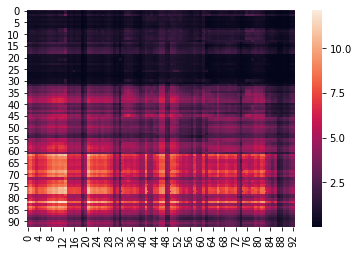

In [27]:
sns.heatmap(normalized_mat["I"])

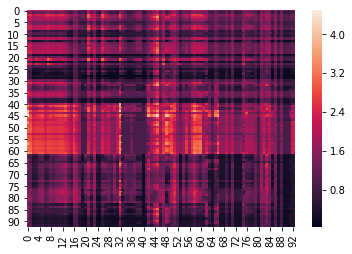

In [20]:
sns.heatmap(normalized_mat["S"])

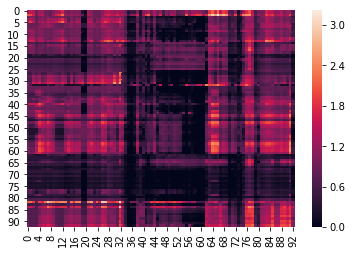

In [21]:
sns.heatmap(normalized_mat["Q"])

## Defining edge types

In [25]:
edge = {}
for k,v in normalized_mat.items():
    edge[k] = v.stack().reset_index().rename(columns={0:"weight", "level_0":"source", "level_1":"target"})

In [61]:
edge["I"].head()

,source,target,weight
0,0,0,0.9206
1,0,1,1.4323
2,0,2,1.3319
3,0,3,1.1326
4,0,4,1.2751


In [26]:
combined_edges = edge["I"].merge(edge["S"].merge(edge["Q"], on=["source", "target"]), on=["source", "target"])
combined_edges.columns = ["source", "target", "weight_I", "weight_S", "weight_Q"]

In [27]:
combined_edges['weight_sum'] = combined_edges["weight_I"] + combined_edges["weight_S"] + combined_edges["weight_Q"]
combined_edges['norm_weight_I'] = combined_edges["weight_I"] / combined_edges['weight_sum']
combined_edges['norm_weight_S'] = combined_edges["weight_S"] / combined_edges['weight_sum']
combined_edges['norm_weight_Q'] = combined_edges["weight_Q"] / combined_edges['weight_sum']
combined_edges.head()

,source,target,weight_I,weight_S,weight_Q,weight_sum,norm_weight_I,norm_weight_S,norm_weight_Q
0,0,0,0.9206,2.3521,1.4272,4.6999,0.1959,0.5005,0.3037
1,0,1,1.4323,2.3779,1.6164,5.4266,0.2639,0.4382,0.2979
2,0,2,1.3319,1.9625,1.5050,4.7994,0.2775,0.4089,0.3136
3,0,3,1.1326,2.1334,0.9188,4.1848,0.2706,0.5098,0.2196
4,0,4,1.2751,2.1467,1.2789,4.7007,0.2713,0.4567,0.2721


In [28]:
signed_edges = {}

for idx, row in combined_edges.iterrows():
    edge_prob = []
    edge_prob.append(row['norm_weight_I'])
    edge_prob.append(row['norm_weight_S'])
    edge_prob.append(row['norm_weight_Q'])
    signed_edges[(row['source'], row['target'])] = edge_prob

In [30]:
combined_edges.to_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/edge_type.csv")

# Build the combined graph and walk

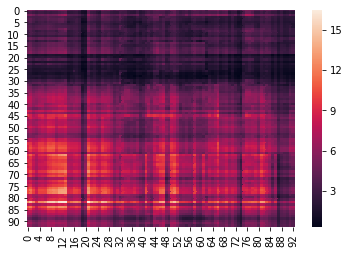

In [28]:
total_mat = normalized_mat["I"] + normalized_mat["S"] + normalized_mat["Q"]
sns.heatmap(total_mat)

In [32]:
tmp = graph_utils.keep_k_percentile_of_each_col_and_each_row(graph_utils.apply_doubly_stochastic(total_mat), 0.3)

In [35]:
np.sum(tmp, axis=0)

0    0.3183
1    0.2972
2    0.2921
3    0.3185
4    0.3333
      ...  
88   0.4481
89   0.4446
90   0.4732
91   0.4667
92   0.4431
Length: 93, dtype: float64

In [54]:
percentile = 0.30

mask = graph_utils.keep_k_percentile_of_each_col_and_each_row(total_mat, percentile)
double_stochastic = graph_utils.apply_doubly_stochastic(mask)

In [55]:
double_stochastic.to_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/run2/graph.csv")

In [4]:
double_stochastic = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/run2/graph.csv", index_col="Unnamed: 0")
double_stochastic.index = [str(i) for i in double_stochastic.index]

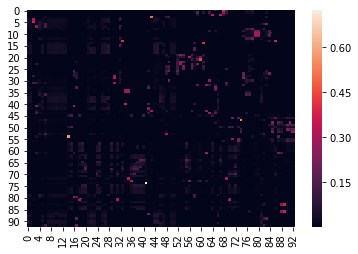

In [5]:
%matplotlib inline
sns.heatmap(double_stochastic)

In [57]:
edges = graph_utils.build_edge_list(weight_matrix=double_stochastic, threshold=None, directed=True)
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)
BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

Building a directed graph edge list
Checking all the weights on all the edges!
Computing the node importance!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


In [58]:
utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/run2/Jan12_walk_100s_100l.csv", walks)

Done writing!


## Results

In [26]:
prefix = "/run3/output"
finished_epoch = 2900 + 100
nandcg_E = []
nandcg_R = []
for e in range(0, finished_epoch, 100):
    epoch = e
    n_emb = 5

    E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/" + 
                    prefix + "_" + str(epoch) + "_E_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")
    R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_7.0/" + 
                    prefix + "_" + str(epoch) + "_R_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")

    E.index = E.index.astype(str)
    R.index = R.index.astype(str)
    

    E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(E[["Z" + str(i) for i in range(n_emb)]], 
                                                                                        R[["Z" + str(i) for i in range(n_emb)]])
    
    nandcg_E.append(analysis.Compute_node_average_ndcg(adj=double_stochastic, e_to_r=E_to_R_dist, k=7))   
    nandcg_R.append(analysis.Compute_node_average_ndcg(adj=double_stochastic.T, e_to_r=E_to_R_dist.T, k=7))   

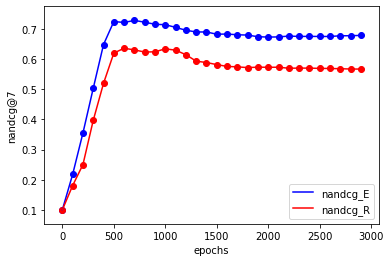

In [9]:
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_E, color='blue')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_E, color='blue', label='nandcg_E')
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_R, color='red')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_R, color='red', label='nandcg_R')
plt.xlabel("epochs")
plt.ylabel("nandcg@7")
plt.legend()

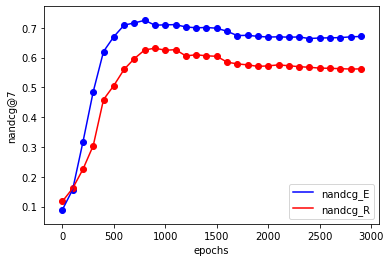

In [31]:
%matplotlib inline
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_E, color='blue')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_E, color='blue', label='nandcg_E')
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_R, color='red')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_R, color='red', label='nandcg_R')
plt.xlabel("epochs")
plt.ylabel("nandcg@7")
plt.legend()

In [30]:
# plt.plot(pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/run_results/signed_npp_version1_30percentile_run3_sign_loss.csv", header=None).loc[0].tolist())

In [37]:
emit, rece = analysis.summarize_embedding_results(E, R, "cluster_label", cldf)

In [38]:
emb_umap = analysis.Compute_umap(pd.concat((emit, rece)), 5)
em = emb_umap[emb_umap['node_act']=="E"]
em = em.set_index('cluster_id')

re = emb_umap[emb_umap['node_act']=="R"]
re = re.set_index('cluster_id')

In [44]:
%matplotlib qt5
plot_utils.plot_ER(emitter=em,
                  receiver=re,
                  figsize=(10,10),
                  plot_dim=2,
                  annotation=False,
                  resolution="cluster_label",
                  side_by_side=True,ylim=(-7,10),
                  )

In [25]:
df = analysis.get_closest_nodes(emb=pd.concat([emit, rece]), 
                           index=["E_" + i for i in E.index.tolist()] + ["R_" + i for i in R.index.tolist()], 
                           node="E_62",
                           topn=5, 
                           coordinate_cols=["Z0", "Z1"])
# plot_utils.plot_3D(df, annotation=True, annotation_col="cluster_label")
df

,Z0,Z1,node_act,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,dist
E_62,-1.4841,1.0831,E,85,Sst Chodl,#FFFF00,#FFFF00,5,Sst,#F15A29,1,GABAergic,#EF4136,0.0000
E_63,-1.4861,1.0841,E,86,Sst Mme Fam114a1,#FFBB33,#FFBB33,5,Sst,#F15A29,1,GABAergic,#EF4136,0.0022
E_77,-1.4799,1.0844,E,100,Sst Crh 4930553C11Rik,#C77767,#C77767,5,Sst,#F15A29,1,GABAergic,#EF4136,0.0044
E_84,-1.4797,1.0853,E,107,Pvalb Th Sst,#FF2F7E,#FF2F7E,6,Pvalb,#D93137,1,GABAergic,#EF4136,0.0050
E_82,-1.4808,1.0879,E,105,Sst Nts,#A81111,#A81111,5,Sst,#F15A29,1,GABAergic,#EF4136,0.0058


In [602]:
np.argsort(-1 * double_stochastic.loc['62'])[0:5]

0    20
1    37
2    19
3    41
4    39
Name: 62, dtype: int64

In [603]:
np.argsort(-1 * double_stochastic.loc['79'])[0:5]

0    73
1    74
2    69
3    81
4    66
Name: 79, dtype: int64

In [610]:
combined_edges[(combined_edges.source=="62") & (combined_edges.target=="20")]

,source,target,weight_I,weight_E,weight_Q,weight_sum,norm_weight_I,norm_weight_E,norm_weight_Q
5786,62,20,0.0454,0.0787,0.0000,0.1241,0.3659,0.6341,0.0000


In [52]:
combined_E_R = R.reset_index().merge(E.reset_index(), on = "index")
combined_E_R.columns = ["cluster_id","Z0", "Z1", "Z2", "Z3"]
combined_E_R = combined_E_R.set_index("cluster_id", drop=True)
combined_E_R = combined_E_R.merge(cldf, on="cluster_id")

In [53]:
umap_emb = analysis.Compute_umap(combined_E_R, 4)
umap_emb = umap_emb.set_index("cluster_id", drop=True)

In [54]:
%matplotlib qt5
fig = plot_utils.plot_embedding(umap_emb, 2, annotation=True, scatter_point_size=100)

In [613]:
cldf.loc[['86']]

,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,
86,109,Pvalb Akr1c18 Ntf3,#FF4343,#FF4343,6,Pvalb,#D93137,1,GABAergic,#EF4136
